# Master File

**Calculating Correlation for Coca-Cola company**

In this file, you will find all the functions from the Google Trends Data & Stock Analysis files as well as our calculations to obtain the correlation coefficient. We intentionally left out any extensive descriptions of the functions from this notebook to keep it uncluttered. If you would like to see our theory behind these functions, more in-depth explanations, and test cases, please visit our other two notebooks.

At the bottom of the file, we will be using these functions to calcuate the correlation between our stock returns and trends data for n-lags.

### Import all necessary packages:

In [4]:
try: #for making web requests
    from urllib.request import urlopen, Request
    from urllib.error import HTTPError
except ImportError:
    from urllib2 import urlopen, Request, HTTPError
    
import pandas as pd
import numpy as np
import lxml
import requests
import requests_cache
import pytrends
from pytrends.request import TrendReq
from bs4 import BeautifulSoup
from collections import Counter

# for plotting & manipulating datetimes
from matplotlib.dates import date2num       
from matplotlib.dates import DateFormatter
from matplotlib import mlab as mlab
from matplotlib import pyplot as plt
import datetime as DT
plt.style.use('ggplot')

requests_cache.install_cache("cache")
#%matplotlib inline # only for python 3

# required info
google_username = "skhaniyur@gmail.com"
google_password = "Shadowcat2312!"

# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq(google_username, google_password, custom_useragent=None)

### Import all necessary functions:

From Goolge Trends Data file:

In [5]:
# function to quickly change the search term list into a list of lists
def listit(t):
    term_listed = []
    term_listed.append(t)
    return term_listed

In [6]:
# function to get each company's data frame separately - includes past 3 years and categories
def get_term_df2(term, cat_num):
    pytrend.build_payload(kw_list = term, cat = cat_num, geo = 'US', timeframe = '2014-01-05 2017-03-11')
    new_df = pytrend.interest_over_time()
    return new_df

In [43]:
# function to obtain correlation coefficient for n-lags
def calc_corr(n_lag):
    if n_lag == 0:
        return result.corr(l)
    else:
        r = result.iloc[n_lag:]
        t = l.iloc[:-n_lag]
        if len(r) == len(t):
            return r.corr(t)
        else:
            print "Not same length"

From Stock Analysis file:

In [8]:
# function to get historical stock data from Yahoo Finance
def getYahooFinanceStockData(stock = '^GSPC', fromMonth = '01', fromDay = '01', fromYear = '1960'):
    #build the url and read the full contents as a string (going back in time upto start of specified year)
    url = 'http://ichart.finance.yahoo.com/table.csv?s=' + stock + '&a=' + fromMonth + '&b=' + fromDay + '&c=' + fromYear
    fulltext = urlopen(url).read().decode('utf-8')
  
    #split the fulltext into individual lines based on the newline character
    fulltextlines = fulltext.splitlines()

    #split the lines into headers and an array of data, based by comma characters
    header = fulltextlines[0].split(',')    #for now, fine to just discard the header...
    data = np.array([line.split(',') for line in fulltextlines[1:]])
  
    #note, if you wanted to return reported closing values instead of adjusted closing values, use column data[4] instead of data[6].
    adjustedClosingPrices = data[:,6].astype(np.float)  #convert it to an array of floats instead of strings.
    closing_dates = data[:,0]
  
    return closing_dates, adjustedClosingPrices

In [9]:
# calcualtes the lognormal return from a specified stock over n days
def calcLogNormalStockReturns(stockPrices = np.empty(0), n_days=1):   
    n_day_lognormal_returns = np.empty(len(stockPrices) - n_days)
    # n-day training return; use "-n" to omit oldest n days that won't have a pair with which to compare
    for i in range(len(stockPrices) - n_days):      
        n_day_lognormal_returns[i] = np.log(float(stockPrices[i]) / float(stockPrices[i+n_days]))
  
    return n_day_lognormal_returns

In [10]:
# calcualtes the percent return from a specified stock over n days
def calcPercentStockReturns(stockPrices = np.empty(0), n_days=1):
    n_day_percent_returns = np.empty(len(stockPrices) - n_days)
    
    # n-day training return; use "-n" to omit oldest n days that won't have a pair with which to compare
    for i in range(len(stockPrices) - n_days):
        n_day_percent_returns[i] = (float(stockPrices[i]) - float(stockPrices[i+n_days])) / float(stockPrices[i+n_days]) *100
  
    return n_day_percent_returns

In [11]:
# helper function to get sundays
def precedingSunday(d):
    #Note, for datetime.weekday: sunday=6, monday=0, tuesday=1, wedesday=2, thursday=3, friday=4, saturday=5.
    if d.weekday() == 6: 
        return d
    else: 
        return d - DT.timedelta(days = d.weekday() + 1)

# avg returns per week & reorder
def avgWeeklyAndReorder(in_dates = np.empty(0), in_returns = np.empty(0)):
    '''Definition: Take an array of daily stock returns and returns an array of average weekly stock returns in reverse order, labeled from Sundays.
    Input: a numpy array of daily real number n-day stock returns, with oldest values last; a corresponding numpy array of string dates.
    Output a numpy array of weekly average real number n-day stock returns, with oldest values first (to match order of Google Trends data)
     a numpy array of corresponding string dates (referenced by the preceding Sunday)
    Note: assumes the oldest date in the daily returns input array is a Monday.'''
    
    #reverse the input arrays to be oldest first, convert string dates to datetime objects
    dates = np.array([DT.datetime.strptime(d, "%Y-%m-%d") for d in in_dates[::-1]])
    returns = in_returns[::-1]
    
    #identify the Sundays before the first and last dates in our input time series (of weekdays), and # of weeks between
    oldestSun = precedingSunday(dates[0])
    newestSun = precedingSunday(dates[len(dates)-1])
    weeksBetween = int((newestSun - oldestSun).days / 7)
    
    #create an array of datetimes for all Sundays beginning a trading week in our dataset (and empty array for its avg returns)
    weeks = np.array([oldestSun + DT.timedelta(days = 7 * w) for w in range(weeksBetween + 1)])
    wreturns = np.zeros(len(weeks))
    
    #average the n-day returns across each day in the week, for all weeks (note weeks with holidays have fewer trading days)
    w, wsum, count = 0,0,0
    for i, d in enumerate(dates):
        #print('in for:', ' i=',i, ' d=',d, ' w=',w)
        if d < weeks[w] + DT.timedelta(days=7):         #if day d is in week w (i.e., is not yet in the following week)
            count += 1                                  #increase the count of trading days in the week
            wsum += returns[i]                          #increase the sum of n-day returns in the week
        else:
            wreturns[w] = wsum / count                  #calculate avg n-day return for preceding week
            
            
            count, wsum = 0,0                           #reset local vars for next week
            w += 1                                      #set weekly counter for next week    
            
            count += 1                                  #increase the count of trading days (for d, the first day in the next week)
            wsum += returns[i]                          #increase the sum of n-day returns (for d, the first day in the next week)
            
    if wreturns[w] == 0: 
        wreturns[w] = wsum / count      #calculate average for the final week, if not accounted for above
    
    return weeks, wreturns

In [12]:
# take a time series of stock returns and return a binary time series identifying some percent of worst returns in that period
def worstReturns(stock_returns = np.empty(0), pWorst = 5):
    worst_ones = np.zeros(len(stock_returns), dtype=int)
    p = np.percentile(stock_returns, pWorst)  #identify all values less than this.
    for i in range(len(stock_returns)):
        if stock_returns[i] <= p: worst_ones[i] = 1
    
    return worst_ones

## Obtaining the data:

Below, we obtain the necessary data and mold it to fit our needs.

In [29]:
##### CODE TESTING WITH COCA-COLA #####

# search terms & categories being used
KO_search_terms = ['coca-cola', '"coca cola"', 'KO', 'coke']
cat_list = [7,12,16]
cat_names = ['Financial', 'Business & Industrial', 'News']

# request using API & match it to financial data
KO_list = [listit(t) for t in KO_search_terms]
all_df = pd.concat([get_term_df2(x, i) for x in KO_list for i in cat_list], axis = 1)
result = all_df.mean(axis=1)
result = result.loc["2014-02-09":]

In [15]:
stocks = ['KO'] # can add more stocks if wanted
n_days = 5
month = '1'
day = '1'
year = '2014'

# get closing dates, stock prices, and stock returns
for stock in stocks:  
    closing_dates, stock_prices = getYahooFinanceStockData(stock, month, day, year)
    stock_returns = calcPercentStockReturns(stock_prices, n_days)

In [17]:
# obtain sundays and average weekly returns that have been reordered 
sundays_of_weeks, weekly_returns = avgWeeklyAndReorder(closing_dates[0:len(closing_dates)-n_days], stock_returns)

for i in range(len(sundays_of_weeks)): print i, '\t', sundays_of_weeks[i], '\t', weekly_returns[i]

0 	2014-02-09 00:00:00 	2.67667848078
1 	2014-02-16 00:00:00 	-3.44571656916
2 	2014-02-23 00:00:00 	0.802121125882
3 	2014-03-02 00:00:00 	1.26349162692
4 	2014-03-09 00:00:00 	0.611630378195
5 	2014-03-16 00:00:00 	0.133650694022
6 	2014-03-23 00:00:00 	0.886788298101
7 	2014-03-30 00:00:00 	-0.879612766889
8 	2014-04-06 00:00:00 	1.22415886681
9 	2014-04-13 00:00:00 	3.09612778722
10 	2014-04-20 00:00:00 	2.59045871983
11 	2014-04-27 00:00:00 	0.108157453164
12 	2014-05-04 00:00:00 	-0.175805142908
13 	2014-05-11 00:00:00 	0.232581624674
14 	2014-05-18 00:00:00 	-0.443531698346
15 	2014-05-25 00:00:00 	0.111691459521
16 	2014-06-01 00:00:00 	0.447703290604
17 	2014-06-08 00:00:00 	-0.08382780282
18 	2014-06-15 00:00:00 	1.9315489735
19 	2014-06-22 00:00:00 	1.52807686744
20 	2014-06-29 00:00:00 	0.955852633255
21 	2014-07-06 00:00:00 	-0.520121703055
22 	2014-07-13 00:00:00 	0.376877108168
23 	2014-07-20 00:00:00 	-2.21870998696
24 	2014-07-27 00:00:00 	-3.4566363083
25 	2014-08-03 

('number of zero or one flags for worst 5% of avg weekly 5-day returns:', 162)
('number of returns in the bottom 5% (where mask == 1):', 9)
('number of dates corresponding to the bottom 5% (where mask == 1):', 9, '\n')


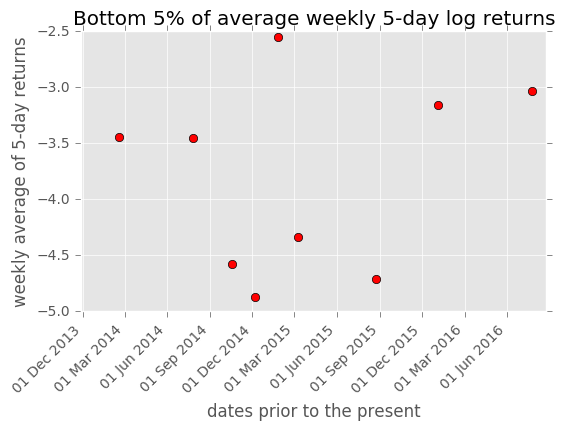

Here are the 5% worst average weekly 5-day returns from the dataset:
(datetime.datetime(2014, 2, 16, 0, 0), '\t', -3.4457165691591536)
(datetime.datetime(2014, 7, 27, 0, 0), '\t', -3.4566363083045744)
(datetime.datetime(2014, 10, 19, 0, 0), '\t', -4.579777198208606)
(datetime.datetime(2014, 12, 7, 0, 0), '\t', -4.8696642890806938)
(datetime.datetime(2015, 1, 25, 0, 0), '\t', -2.5556991815928982)
(datetime.datetime(2015, 3, 8, 0, 0), '\t', -4.3401908523870176)
(datetime.datetime(2015, 8, 23, 0, 0), '\t', -4.7166083995831709)
(datetime.datetime(2016, 1, 3, 0, 0), '\t', -3.1621098585356981)
(datetime.datetime(2016, 7, 24, 0, 0), '\t', -3.0344465831612375)


In [47]:
# get binomial list where 1 means there was a significant loss
bottom5Mask = worstReturns(weekly_returns, 5)
bottom5Returns = np.array([r for r, mask in zip(weekly_returns, bottom5Mask) if mask == 1])
bottom5Dates = np.array([d for d, mask in zip(sundays_of_weeks, bottom5Mask) if mask == 1])
print('number of zero or one flags for worst 5% of avg weekly 5-day returns:', len(bottom5Mask))
print('number of returns in the bottom 5% (where mask == 1):', len(bottom5Returns))
print('number of dates corresponding to the bottom 5% (where mask == 1):', len(bottom5Dates), '\n')

# plot it...
pltdata = []
for i in range(len(bottom5Returns)):
    pltdata.append((bottom5Dates[i], bottom5Returns[i]))
x = [date2num(date) for (date, value) in pltdata]
y = [value for (date, value) in pltdata]
fig, ax = plt.subplots()
ax.plot(x,y, 'ro')
ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y')) #('%b %d %Y'))
ax.xaxis_date()  #tell matplotlib to interpret the x-axis values as dates
plt.gcf().autofmt_xdate(rotation=45) #rotate the x labels
plt.title('Bottom 5% of average weekly 5-day log returns')
plt.ylabel('weekly average of 5-day returns')
plt.xlabel('dates prior to the present')
plt.show()

# display it...
print('Here are the 5% worst average weekly 5-day returns from the dataset:')
for i in range(len(bottom5Returns)): print(bottom5Dates[i], '\t', bottom5Returns[i])

## Calculations:

Now we have reached the exciting part where we actually test our code with the Coca-Cola company to calculate the correlation between stock returns and search trends data.

In [46]:
# turn binary into time series
l = pd.Series((v for v in bottom5Mask))
l = l[:-1]
l.index = result.index

In [44]:
# calculate cross-correlation for lags 0-9
corrs = [calc_corr(x) for x in range(0,10)]
corrs

[0.14282667837605206,
 0.14416963983669659,
 0.10636765945778787,
 0.11085664238847201,
 0.11538006254286995,
 0.12678148139221568,
 0.13094779864067041,
 0.13139804538214236,
 0.13182985713970605,
 0.13305481844354627]

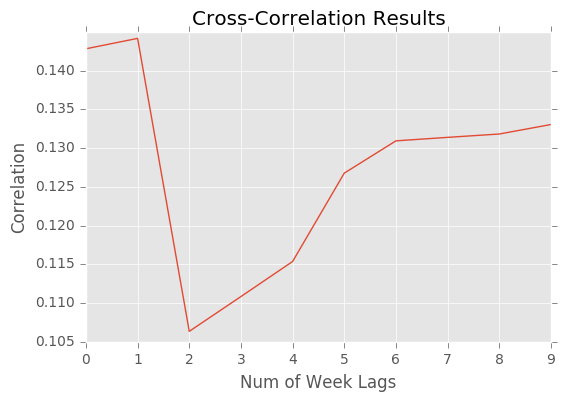

In [48]:
# plot the correlations
plt.plot(range(10), corrs)
plt. title('Cross-Correlation Results')
plt.xlabel('Num of Week Lags')
plt.ylabel('Correlation')
plt.show()